In [1]:
%pylab inline
from numpy import *
from matplotlib.pyplot import *
from scipy.optimize import leastsq
import emcee

#variables
pi = 3.14159265359 
G = 6.67384*10**-11
c = 299792.458 #km/s

#imports
z = recfromtxt ('Desktop/z.txt')
mu = recfromtxt ('Desktop/mu.txt')
sigma = recfromtxt ('Desktop/sigma.txt')


Welcome to pylab, a matplotlib-based Python environment [backend: module://IPython.zmq.pylab.backend_inline].
For more information, type 'help(pylab)'.

Omega_m = .23 fits the data better than the Omega_m = 1 case.

-c:34: RuntimeWarning: divide by zero encountered in log10
-c:35: RuntimeWarning: divide by zero encountered in log10

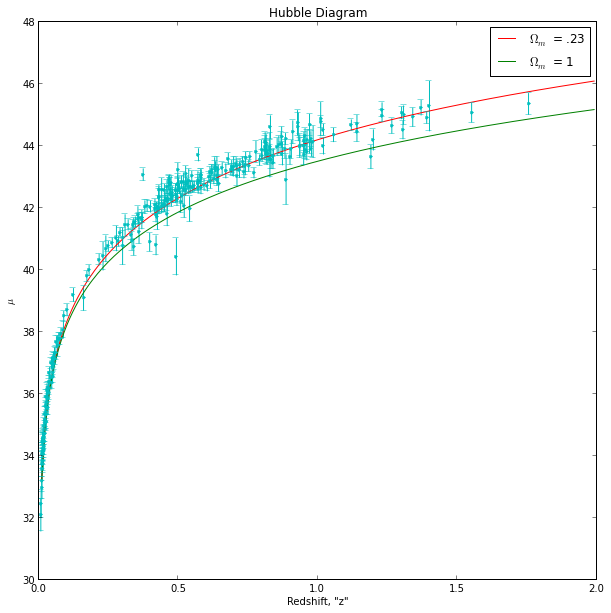

In [2]:
#print len(sigma), len(mu), len(z)
from scipy.integrate import quad
q = 0
i = 0

Om1 = .23
Om2 = 1
h = 0.7
H0 = 70 #km/s/Mpc
Ol1 = 1-Om1
Ol2 = 1-Om2

Dh = 3000
d = zeros(200)
Dc = zeros(200)
Dc2 = zeros(200)
Dl = zeros(200)
Dl2 = zeros(200)
mu2 = zeros(200)
mu3 = zeros(200)
while (q < 2):
    def integrand(q):
        return 1/sqrt(Om1*(1+q)**3 + Ol1)
    def integrand2(q):
        return 1/sqrt(Om2*(1+q)**3 + Ol2)
    Q = quad(integrand, 0, q)
    Q2 = quad(integrand2, 0, q) 
    #print Q
    Dc[i] = Q[0]*Dh
    Dc2[i] = Q2[0]*Dh
    d[i] = q
    Dl[i] = (1 + q)*Dc[i]
    Dl2[i] = (1 + q)*Dc2[i]
    mu2[i] = 25 - 5*log10(.7) + 5*log10(Dl[i])
    mu3[i] = 25 - 5*log10(.7) + 5*log10(Dl2[i])
    if (i == 0):
        mu2[i] = mu2[i] + .000000000000000000001 #~0, I put this in so I wouldnt get an error
        mu3[i] = mu3[i] + .000000000000000000001 #~0, I put this in so I wouldnt get an error
    i = i + 1
    q = q + .01
figure(figsize=(10,10))
#print mu2, '\n', mu3
plot(d, mu2, 'r', label = '$\Omega_m$ = .23')
plot(d, mu3,'g', label = '$\Omega_m$ = 1')
errorbar(z, mu, sigma, fmt = 'c.')
title('Hubble Diagram')
xlabel('Redshift, "z"')
ylabel('$\mu$')
legend()

print 'Omega_m = .23 fits the data better than the Omega_m = 1 case.'

### 3(a): You can get the best fit model by manipulating the h and Omega_m in order to get a mu_theoretical that allows Chi^2 to be close to 1.

In [11]:
from scipy.optimize import fmin

def integrand(x, OhMnh):
    Ohm = OhMnh[0]
    ohm2 = 1- Ohm 
    return (1/sqrt(Ohm*(1+x)**3 + ohm2))
Ohm = .23
h = .7
OhMnh = [Ohm, h]
def chisq(OhMnh):#, Dc, Dh, redshift, mu4, Dl, sigma, mu, i):
    x = linspace(0, max(z), 292)
    chi2 = 0
    dist = zeros(292)
    Dc = zeros(292)
    redshift  = zeros(292)
    Dl = zeros(292)
    Dh = 3000
    i = 0
    mu4 = zeros(292)
    #while (x[i] < max(x)):
    for i  in range(0,292):
        Q = quad(integrand, 0, x[i], OhMnh)
        #print Q
        Dc[i] = Q[0]*Dh
        #print Dc[i]
        redshift[i] = x[i]
        #print redshift[i]
        Dl[i] = (1 + x[i])*Dc[i]
        #print OhMnh[1]
        mu4[i] = 25 - 5*log10(OhMnh[1]) + 5*log10(Dl[i])
        if (i != 0):
            chi2 = chi2 + (((mu[i] - mu4[i])**2)/(sigma[i]**2))
        i = i + 1
    return(chi2)
u = linspace(0, max(z), 292)
print fmin(chisq, OhMnh)
''' 
args=(x, Dc, Dh, redshift, mu4, Dl, sigma, mu, i))
figure(figsize = (10,10))
plot(u, mu4, label = '$\Omega_m$ =')
plot(d, mu2, 'r', label = '$\Omega_m$ = .23')
plot(d, mu3,'g', label = '$\Omega_m$ = 1')
errorbar(z, mu, sigma, fmt = 'c.')
title('Hubble Diagram')
xlabel('Redshift, "z"')
ylabel('$\mu$')
legend()
for i in range(0,292):
    if (sigma[i] == 0):
        print 'dog'
print sigma       


print Q, '\n', Q2, '\n',Dc, '\n',Dc2, '\n', d, '\n', Dl, '\n',Dl, '\n',2, '\n', mu2, '\n', mu3
'''

Optimization terminated successfully.
         Current function value: 36120.606773
         Iterations: 87
         Function evaluations: 166
[ 13.02403267   0.62126248]

### The best fit model is with an Omega_matter of .27 and an h of .68.

### The chi^2 shows that it is not a good fit.  Being such a large value while the desired value is usually 1, but in this case 0.

### Part 4a: When you minimize chi^2, you also maximize the likelyhood.

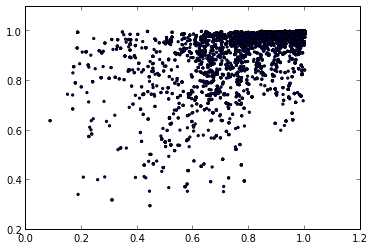

In [9]:
def lnlike(OhMnh):
    if OhMnh[0] < 0 or OhMnh[0] > 1 or OhMnh[1] < 0 or OhMnh[1] > 1:
        return -np.inf
    else:
        return -.5 * chisq(OhMnh)
ndim = 2
nwalkers = 100
p0 = random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
#print len(mu), '\n', len(z), '\n', len(sigma)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike)#, args=[mu, sigma, z])
print sampler
num_breakin = 10
nsteps = 100
#print chain
#print num_breakin
pos, prob, state = sampler.run_mcmc(p0, num_breakin)
sampler.reset()
end_pos, end_prob, end_state = sampler.run_mcmc(pos, nsteps)
plt.scatter(sampler.flatchain[:,0], sampler.flatchain[:,1], marker='.')

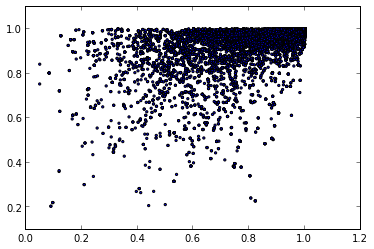

In [10]:
def lnlike(OhMnh):
    if OhMnh[0] < 0 or OhMnh[0] > 1 or OhMnh[1] < 0 or OhMnh[1] > 1:
        return -np.inf
    else:
        return -.5 * chisq(OhMnh)
ndim = 2
nwalkers = 250
p0 = random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
#print len(mu), '\n', len(z), '\n', len(sigma)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike)#, args=[mu, sigma, z])
print sampler
num_breakin = 10
nsteps = 100
#print chain
#print num_breakin
pos, prob, state = sampler.run_mcmc(p0, num_breakin)
sampler.reset()
end_pos, end_prob, end_state = sampler.run_mcmc(pos, nsteps)
plt.scatter(sampler.flatchain[:,0], sampler.flatchain[:,1], marker='.')

### 4c You can see how it deviates instead of just a singular point.

### My estimated Omega matter is .7 and my estimated h is .9.  I am not ready for a Nobel.